### Вопросы:
### Второе задание:
#### 1) Что делать с днями для которых нет "вчера"
Брать предыдущие дни
#### 2) Что делать с днями для которых нет новостей 
#### 3) Как показать "как tfidf влияет на качество классификации"? Может взять по сравнению с bag-of-words или другой примитивной техникой?

# Майнор "Прикладные задачи анализа данных"
## Домашнее задание 2 [10 баллов] до 23:59 22.03.2018. Предсказание цены акции по экономическим новостям


В этом домашнем задании вы попытаетесь предсказать рост цены акции компании Газпром по новостям о компании. Домашнее задание состоит из трех частей:
1. Предварительная обработка текстов и эксплоративный анализ
2. Baseline алгоритм
3. Творческая часть

Все три части можно считать независимыми – вы можете сделать одну или две из них, однако мы настоятельно советуем выполнить все три. Все инструкции по выполнению домашнего задания – ниже. 



Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [5]:
import pandas as pd
texts = pd.read_csv('data/texts.csv')
pr_all = pd.read_csv('data/gazprom_prices.csv', sep=';')

In [6]:
# Проведем чистку данных: приведем дату к соответствующему формату и отсортируем новости, удалим пустые
texts['date'] = pd.to_datetime(texts['date'])
texts = texts.sort_values('date', ascending=True).reset_index(drop=True)
texts['text'] = texts['text'].apply(lambda x: x.strip())
texts = texts[texts['text'] != '']
texts.head()

,date,text
0,2010-01-02,"""Газпром"" не исключает в 2010 г. выпуска облиг..."
1,2010-01-19,"""Газпром"" готов забирать весь объем азербайджа..."
2,2010-01-28,"Консорциум во главе с российским ОАО ""Газпром ..."
3,2010-02-07,Газпромбанк открыл на Кипре дочернюю компанию ...
4,2010-02-09,"""Газпром"" вновь понизил прогноз экспорта в Евр..."


In [7]:
# Новости сплитятся по \n. Сделаем список строк, каждая строка - одна новость
texts['text'] = texts['text'].apply(lambda x: list(x.split('\n')))

In [8]:
# Сделаем тоже самое для датафрейма с ценами
pr_all['Date'] = pd.to_datetime(pr_all['Date'])
pr_all = pr_all.sort_values('Date', ascending=True).reset_index(drop=True)
pr_all[['Open', 'ClosingPrice', 'DailyHigh', 'DailyLow']] =\
pr_all[['Open', 'ClosingPrice', 'DailyHigh', 'DailyLow']].apply(lambda x: x.apply(lambda y: float(str(y).replace(',', '.'))))
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2010-01-02,184.74,189.85,190.40,183.50,76298175
1,2010-01-03,168.70,168.20,170.71,166.33,58570262
2,2010-01-04,172.49,175.00,176.14,172.33,94994135
3,2010-01-06,158.20,159.26,160.31,154.39,67031024
4,2010-01-07,147.00,143.20,147.77,143.04,50067990


In [9]:
# Сделаем общий датафрейм
all_info = texts.merge(pr_all, left_on='date', right_on='Date', how='inner').drop('Date', axis=1)
all_info.sort_values(by='date', inplace=True)
all_info.head()

,date,text,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs
0,2010-01-02,"[""Газпром"" не исключает в 2010 г. выпуска обли...",184.74,189.85,190.40,183.50,76298175
1,2010-01-19,"[""Газпром"" готов забирать весь объем азербайдж...",190.10,189.76,190.47,187.36,48626727
2,2010-01-28,"[Консорциум во главе с российским ОАО ""Газпром...",183.75,182.30,185.98,181.67,62561241
3,2010-02-07,[Газпромбанк открыл на Кипре дочернюю компанию...,144.80,148.25,148.27,144.05,41766629
4,2010-02-09,"[""Газпром"" вновь понизил прогноз экспорта в Ев...",161.79,162.80,163.57,161.53,42721026


In [10]:
all_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1159 entries, 0 to 1158
Data columns (total 7 columns):
date            1159 non-null datetime64[ns]
text            1159 non-null object
Open            1145 non-null float64
ClosingPrice    1159 non-null float64
DailyHigh       1158 non-null float64
DailyLow        1157 non-null float64
VolumePcs       1159 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 72.4+ KB


## Часть 1. Вводная [3 балла]

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* Кого упоминают чаще:
    * Алексея Миллера
    * Владимира Путина?
* О каких санкциях пишут в статьях?

In [11]:
# Функция для токенизации текстов
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def tokenizer(text):
    tokens = word_tokenize(text)
    
    # Сделаем список стоп-слов
    stop_words = stopwords.words('russian')
    stop_words.extend(['г.'])
    
    # Сделаем список знаков припинания
    punctuation = list(string.punctuation)
    punctuation.extend(['«', '»', '""', '—', '``', "''", '–', '“', '”'])
    
    # Удалим из токенов стоп-слова и знаки припинания
    tokens = [i for i in tokens if ((i not in punctuation) and (i not in stop_words))]

    return tokens

In [12]:
# Функция для лемматизации слов
from pymorphy2 import MorphAnalyzer

def lemmatizator(words_list, morph_analyzer):
    return [morph_analyzer.parse(word)[0].normal_form for word in words_list] 

In [13]:
%%time
# Проведем токенизацию
all_info['text'] = [[tokenizer(sen) for sen in day] for day in all_info['text']]

CPU times: user 2.12 s, sys: 40.1 ms, total: 2.16 s
Wall time: 2.18 s


In [14]:
%%time 
# Проведем лемматизацию
morph = MorphAnalyzer()
all_info['text'] = [[lemmatizator(sen, morph_analyzer=morph) for sen in day] for day in all_info['text']]

CPU times: user 19.1 s, sys: 74.6 ms, total: 19.2 s
Wall time: 19.3 s


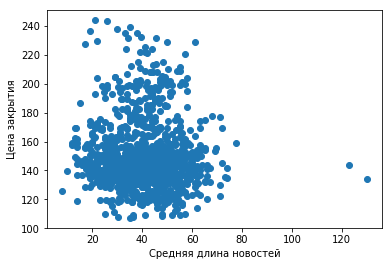

In [17]:
# Корреляции между средней длиной новостей и ценой закрытия нет
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline

len_news = []
for lst_news in all_info['text']:
    len_mean = []
    for news in lst_news:
        len_mean.append(len(news))
    len_news.append(np.mean(len_mean))
    
plt.scatter(y=all_info['ClosingPrice'], x=len_news)
plt.xlabel('Средняя длина новостей')
plt.ylabel('Цена закрытия');

Text(0,0.5,'Количество упоминаний Алексея Миллера')

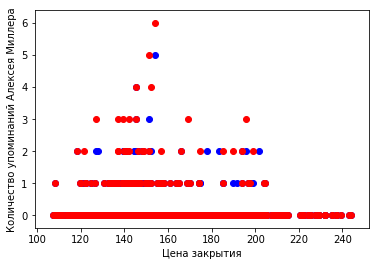

In [21]:
# Можно заметить, что корреляции между упоминаниями Алексея Миллера и ценой закрытия нет
miller_count = []
alexey_count = []
for lst_news in all_info['text']:
    miller_one_text = 0
    alexey_one_text = 0
    for news in lst_news:
        miller_one_text += news.count('миллер') 
        alexey_one_text += news.count('алексей')
    miller_count.append(miller_one_text)
    alexey_count.append(alexey_one_text)

plt.scatter(all_info['ClosingPrice'], alexey_count, c='blue')
plt.scatter(all_info['ClosingPrice'], miller_count, c='red')

plt.xlabel('Цена закрытия')
plt.ylabel('Количество упоминаний Алексея Миллера')

In [26]:
# Видим, что турецкий поток упоминается больше
import nltk

sever_turkish = {'Северный поток': 0, 'Турецкий поток': 0}
for lst_news in all_info['text']:
    for news in lst_news:
        bigrams = list(nltk.bigrams(news))
        if ('северный', 'поток') in bigrams:
            sever_turkish['Северный поток'] += 1
        if ('турецкий', 'поток') in bigrams:
            sever_turkish['Турецкий поток'] += 1
print(sorted(sever_turkish.items(), reverse=True, key=lambda x: x[1]))

[('Турецкий поток', 34), ('Северный поток', 12)]


In [27]:
# Видим, что Миллер упоминается чаще
miller_putin = {'Миллер': 0, 'Путин': 0}
for lst_news in all_info['text']:
    for news in lst_news:
        miller_putin['Миллер'] += news.count('миллер') 
        miller_putin['Путин'] += news.count('путин')    
print(sorted(miller_putin.items(), reverse=True, key=lambda x: x[1]))

[('Миллер', 147), ('Путин', 71)]


In [28]:
sanctions = set()
for lst_news in all_info['text']:
    for news in lst_news:
        bigrams = list(nltk.bigrams(news))
        for bg in bigrams:
            if 'санкция' in bg[0]:
                p = morph.parse(bg[1])[0]        
                if (p.tag.POS) == 'ADJF' or (p.tag.POS) == 'ADJS': #(p.tag.POS) == 'NOUN'
                    sanctions.add(bg[1])
            if 'санкция' in bg[1]:
                p = morph.parse(bg[0])[0]
                if (p.tag.POS) == 'ADJF' or (p.tag.POS) == 'ADJS':# or (p.tag.POS) == 'NOUN':
                    sanctions.add(bg[0])
print ('Характеристика упоминающихся в новостях санкций:\n')
print(*sanctions)

Характеристика упоминающихся в новостях санкций:

западный очередной готовый секторальный финансовый персональный экономический технологический штрафной репутационный который несогласованный американский антироссийский международный


## Часть 2. Классификационная [3 балла]
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

In [56]:
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,2010-01-02,184.74,189.85,190.40,183.50,76298175,NaN
1,2010-01-03,168.70,168.20,170.71,166.33,58570262,0.0
2,2010-01-04,172.49,175.00,176.14,172.33,94994135,1.0
3,2010-01-06,158.20,159.26,160.31,154.39,67031024,0.0
4,2010-01-07,147.00,143.20,147.77,143.04,50067990,0.0


In [53]:
import numpy as np
# Добавим бинарный признак ClosingPrice_bin
pr_all['ClosingPrice_bin'] = pd.Series(data=[np.NaN]+[(1 if pr_all['ClosingPrice'][i]>=pr_all['ClosingPrice'][i-1] else 0)\
                                             for i in np.arange(1, pr_all.shape[0])])

In [54]:
pr_all.head()

,Date,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
0,2010-01-02,184.74,189.85,190.40,183.50,76298175,NaN
1,2010-01-03,168.70,168.20,170.71,166.33,58570262,0.0
2,2010-01-04,172.49,175.00,176.14,172.33,94994135,1.0
3,2010-01-06,158.20,159.26,160.31,154.39,67031024,0.0
4,2010-01-07,147.00,143.20,147.77,143.04,50067990,0.0


## Часть 3. Творческая [4 балла]
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по усредненным эмбеддингам  (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/ или https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     

## Сдача домашнего задания

Дедлайн сдачи домашнего задания:  23:59 22.03.2018. Каждый день просрочки дедлайна штрафуется -1 баллом.

Результаты домашнего задания должны быть оформлены в виде отчета в jupyter notebook.
Нормальный отчёт должен включать в себя:
* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов 
* Подробный пошаговый рассказ о проделанной работе
* **Аккуратно** оформленные результаты
* Подробные и внятные ответы на все заданные вопросы 
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

Задание выполняется в группе до трех человек. Не забудьте перечислить фамилии всех, кто работал над домашнем задании, в jupyter notebook.  

В случае использования какого-либо строннего источника информации обязательно дайте на него ссылку (поскольку другие тоже могут на него наткнуться). Плагиат наказывается нулём баллов за задание и предвзятым отношением в будущем.


При возникновении проблем с выполнением задания обращайтесь с вопросами к преподавателю по семинарским занятиям в вашей группе или у учебным ассистентам.

Учебный ассистент по ДЗ 2: Таисия Глушкова (email: glushkovato@gmail.com, telegram: @glushkovato).


Небрежное оформление отчета существенно отразится на итоговой оценке. Весь код из отчёта должен быть воспроизводимым, если для этого нужны какие-то дополнительные действия, установленные модули и т.п. — всё это должно быть прописано в отчете в явном виде.

Сдача отчетов осуществляется через систему AnyTask.

